Исправлены некоторые ошибки изначальной версии, например, веса атеншена считаются не в течении жизни модели, а при каждом прохождении данных через нее

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, random_split

In [100]:
class TransformerModelWithAttention(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=3, hidden_dim=128, dropout=0.1, max_seq_len=50):
        super(TransformerModelWithAttention, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)

        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, hidden_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(hidden_dim, num_classes)

        self.attention_weights = []

    def forward(self, x):
        batch_size, channels, height, width = x.shape

        patches = x.unfold(2, 7, 7).unfold(3, 7, 7)
        patches = patches.contiguous().view(batch_size, -1, 7*7)

        x = self.embedding(patches)

        seq_len = patches.size(1)
        x = x + self.positional_encoding[:, :seq_len, :]

        encoder_output = self.transformer_encoder(x)

        self.attention_weights = []
        for layer in self.transformer_encoder.layers:
            _, attn_weights = layer.self_attn(
                encoder_output, encoder_output, encoder_output,
                need_weights=True
            )
            self.attention_weights.append(attn_weights.detach())

        x = encoder_output.mean(dim=1)
        return self.fc_out(x)

In [145]:
def evaluate(model, loader, criterion):
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data, target
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total_samples += data.size(0)

    accuracy = 100. * correct / total_samples
    return accuracy

def train_with_logging(model, train_loader, val_loader, optimizer, criterion, num_epoch):
    model.train()
    total_loss = 0
    counter = 0
    losses = []
    vals = []
    print(len(train_loader))
    
    for i in range(num_epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data, target
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            counter += 1
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(loss.item(), batch_idx)
                losses.append(total_loss / counter)
                counter = 0
                total_loss = 0
            if batch_idx % 300 == 0:
                vals.append(evaluate(model, val_loader, criterion))
    return losses, vals

In [146]:
def visualize_attention(model, sample, layer_idx, head_idx):
    model.eval()
    with torch.no_grad():
        _ = model(sample.unsqueeze(0))

        attn_weights = model.attention_weights[layer_idx]

        if attn_weights.dim() == 4:
            attn_map = attn_weights[0, head_idx].cpu().numpy()
        elif attn_weights.dim() == 3:
            attn_map = attn_weights[0].cpu().numpy()
        elif attn_weights.dim() == 2:
            attn_map = attn_weights.cpu().numpy()

    plt.figure(figsize=(10, 8))
    plt.imshow(attn_map, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Attention Map (Layer {layer_idx+1}, Head {head_idx+1})')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.show()

In [147]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist = datasets.MNIST('./data', train=True, download=True, transform=transform)
train, val = train_test_split(mnist, test_size=0.3, random_state=42)

train_loader = DataLoader(train, batch_size=8, shuffle=True)
val_loader = DataLoader(val, batch_size=8)

In [148]:
# Инициализация модели, оптимизатора и функции потерь
model = TransformerModelWithAttention(input_dim=49, num_classes=10)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [149]:
losses, vals = train_with_logging(model, train_loader, val_loader, optimizer, criterion, num_epoch=1)

5250
2.1887917518615723 0
0.6797717809677124 100
1.49560546875 200
1.6860580444335938 300
1.3584461212158203 400
1.3529490232467651 500
1.495495319366455 600
0.8231447339057922 700
0.8598455190658569 800
1.1449166536331177 900
0.9297559261322021 1000
0.8137258887290955 1100
0.7879176139831543 1200
0.2620306611061096 1300
0.6065669059753418 1400
0.5637233257293701 1500
0.20243042707443237 1600
1.306419014930725 1700
0.47367578744888306 1800
0.4244597256183624 1900
0.14206984639167786 2000
0.8885717391967773 2100
0.26137775182724 2200
1.9019783735275269 2300
1.2925492525100708 2400
0.7553821206092834 2500
0.3005565404891968 2600
0.3630712628364563 2700
0.7812073230743408 2800
0.3563253879547119 2900
1.2464122772216797 3000
0.5473113059997559 3100
0.6619397401809692 3200
0.22667326033115387 3300
0.2720363736152649 3400
0.8632705211639404 3500
0.19682946801185608 3600
1.0714333057403564 3700
0.2644881308078766 3800
0.5125439167022705 3900
0.018088223412632942 4000
0.7141508460044861 4100
0

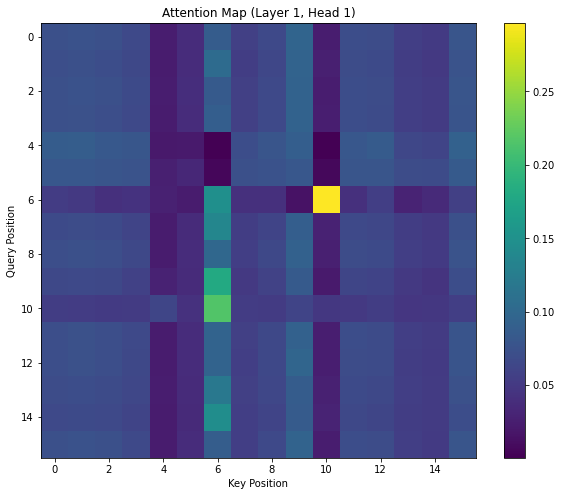

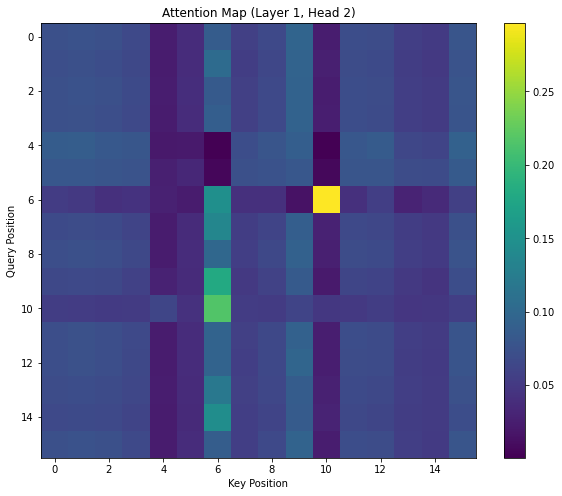

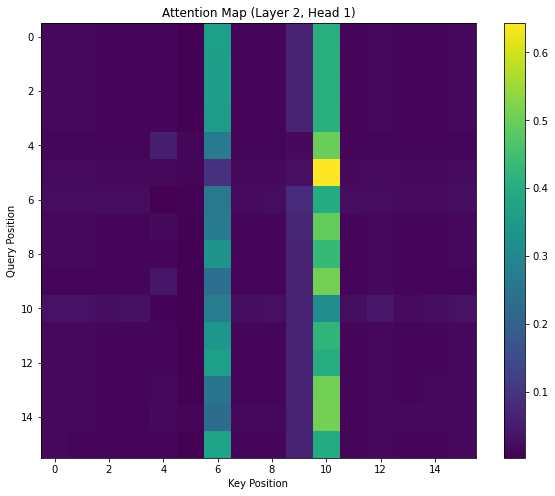

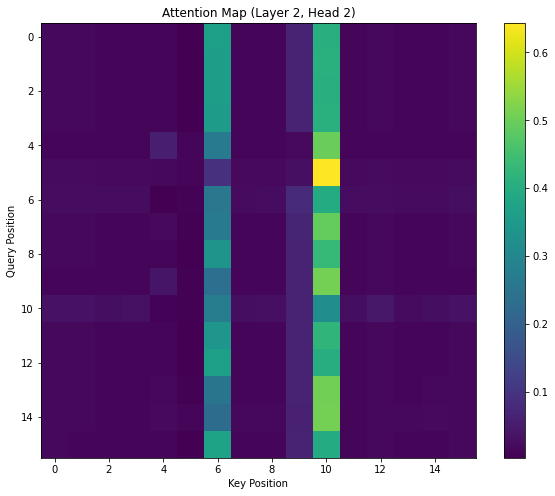

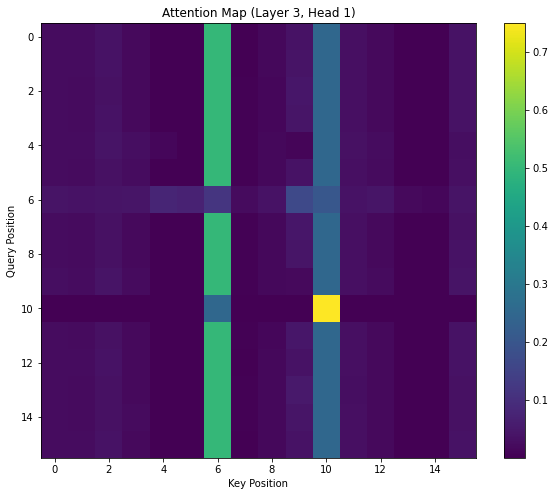

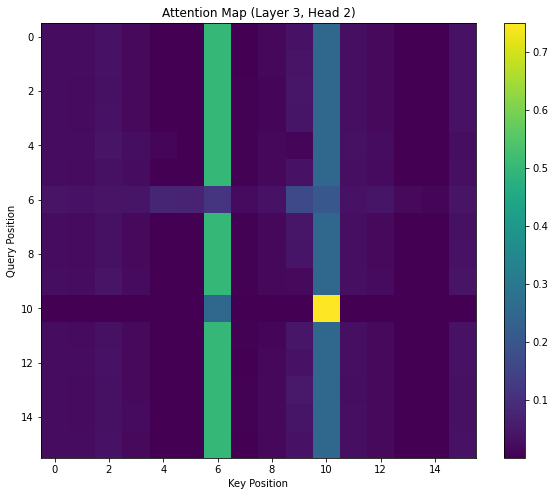

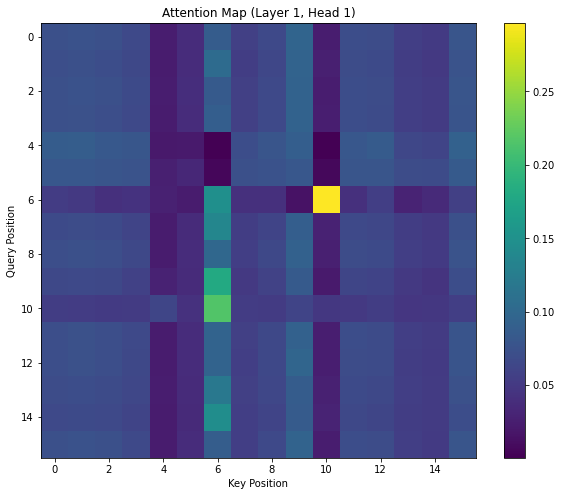

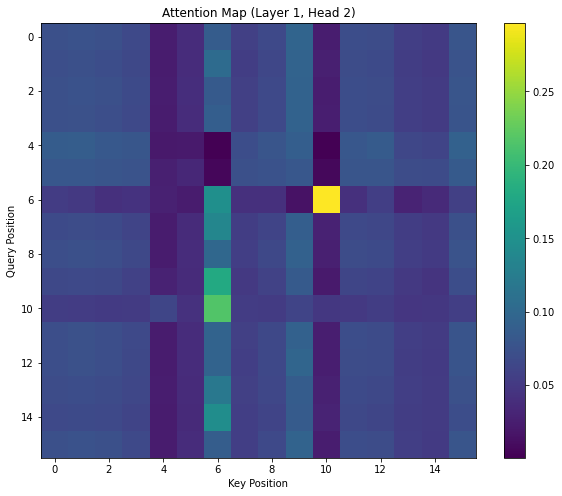

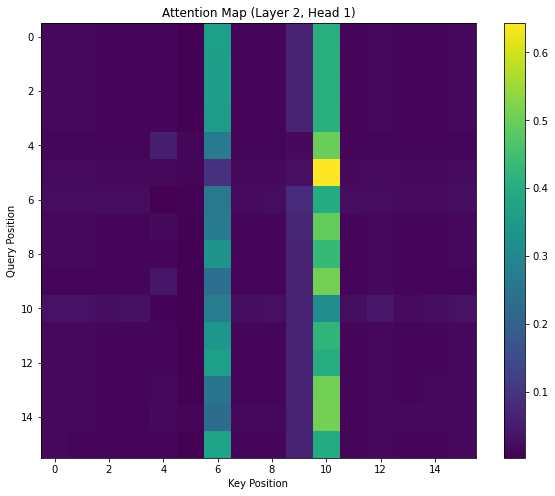

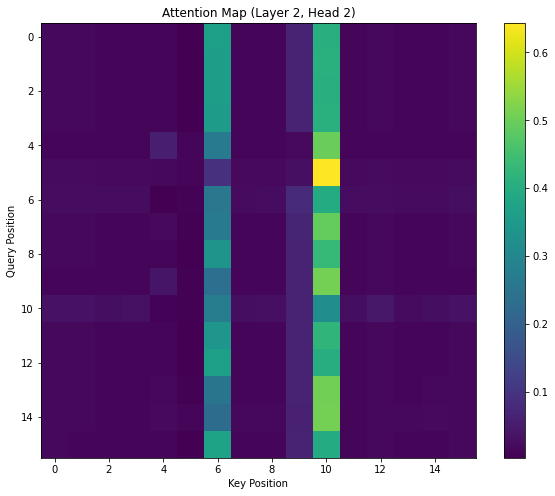

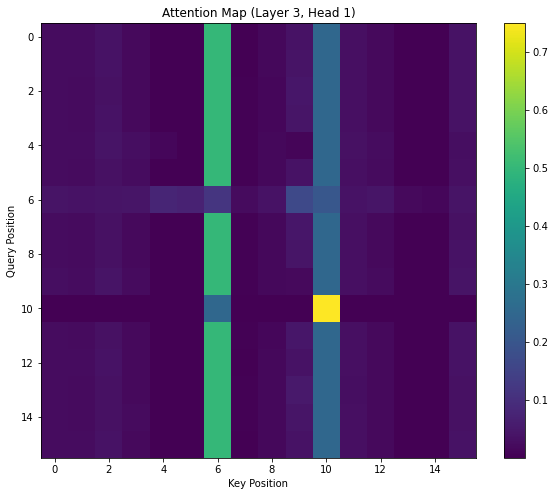

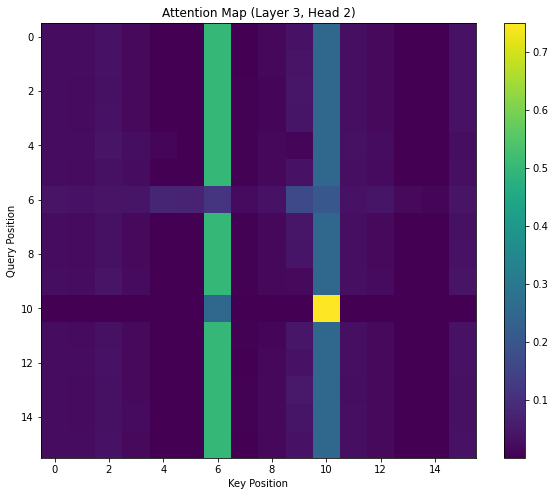

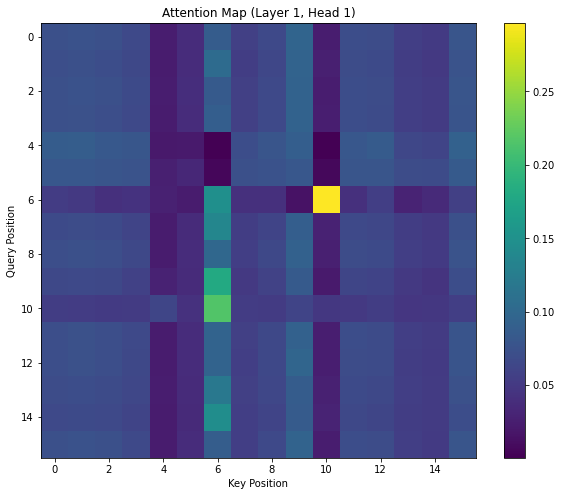

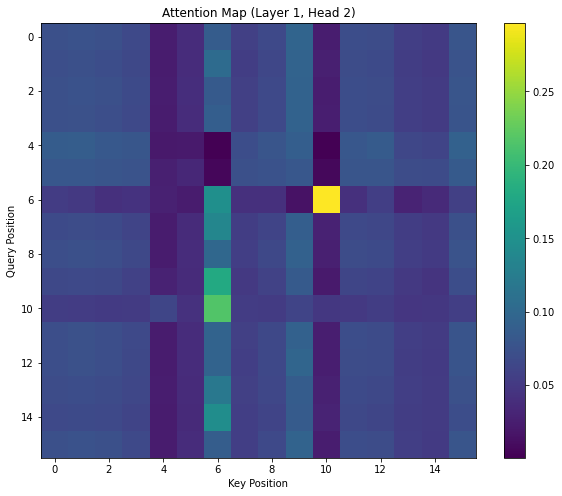

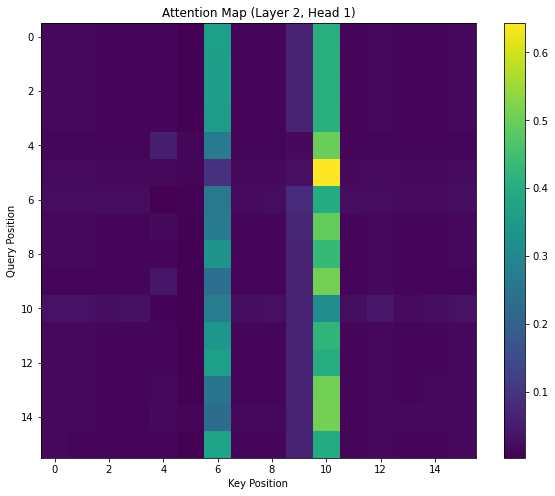

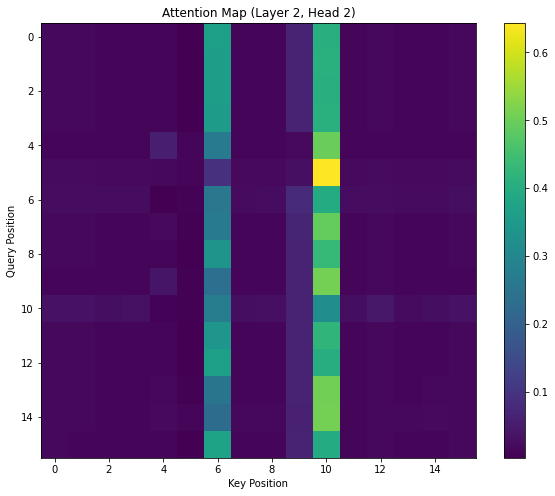

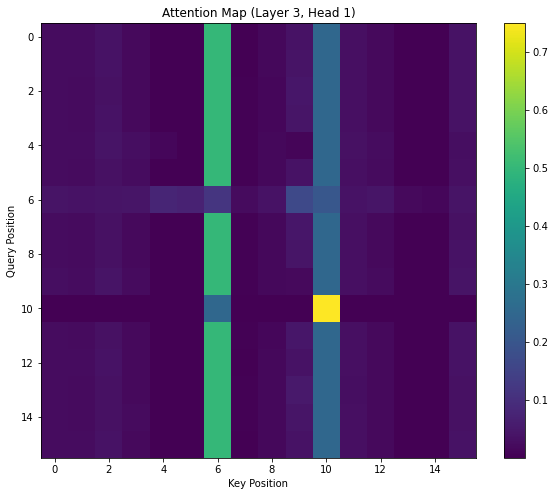

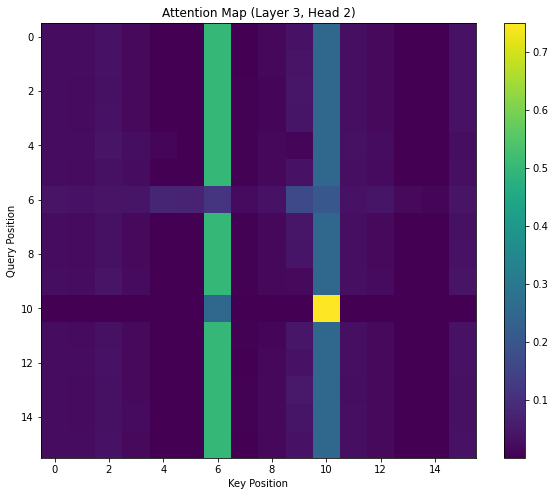

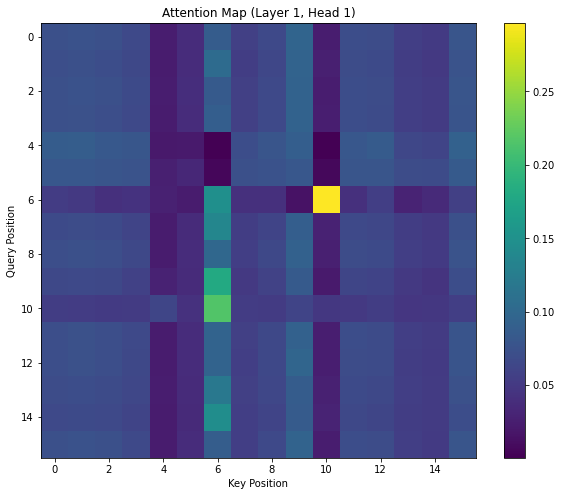

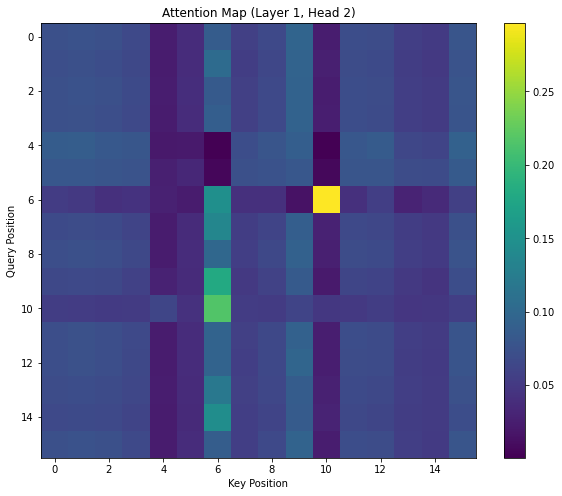

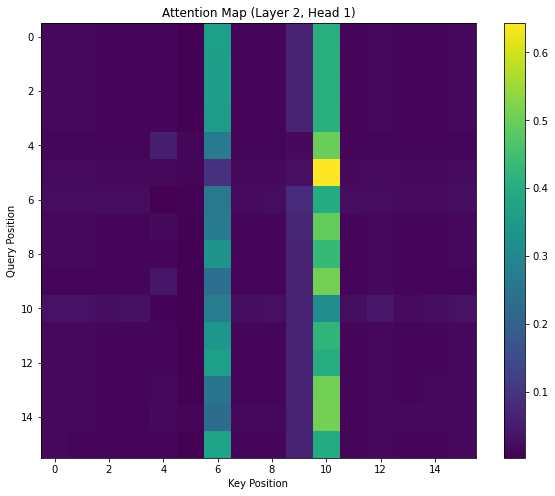

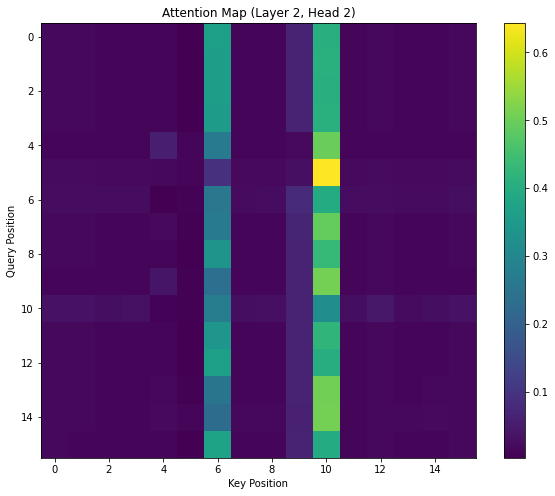

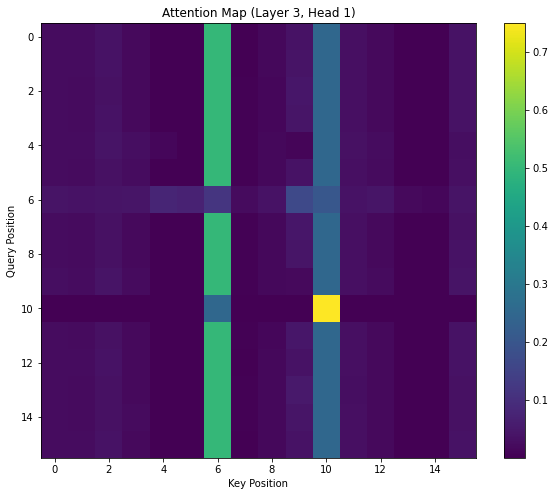

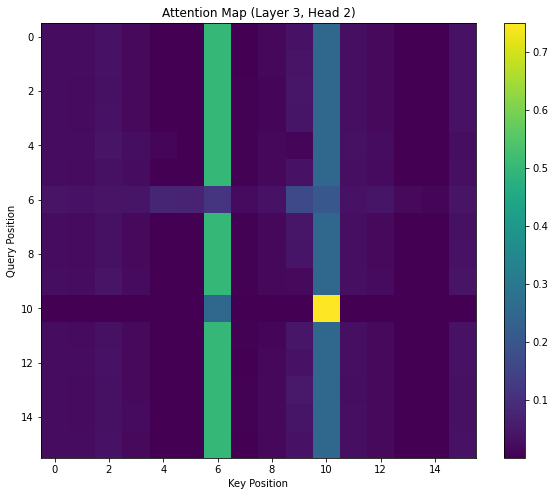

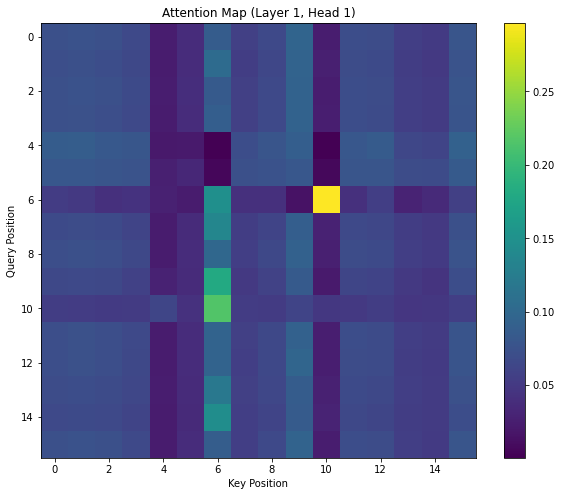

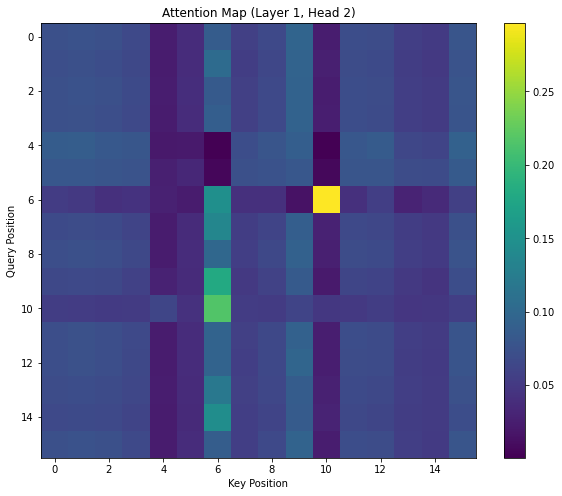

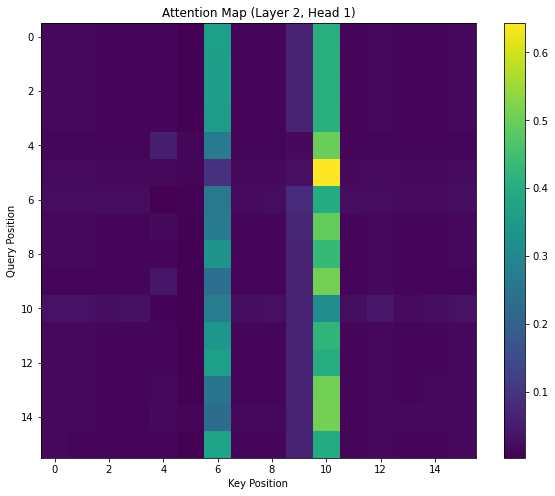

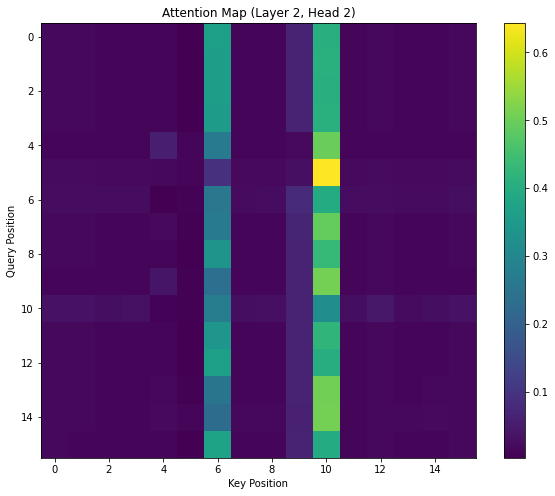

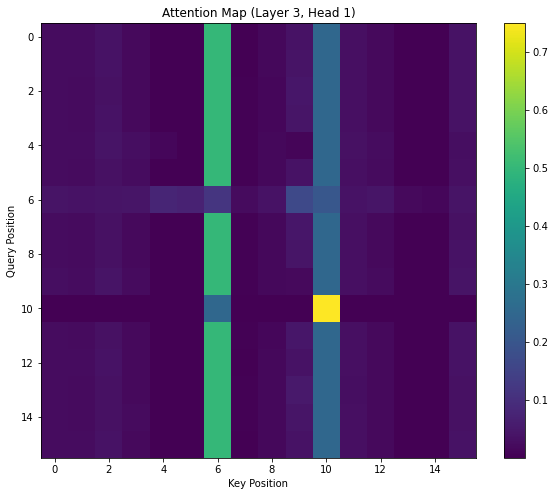

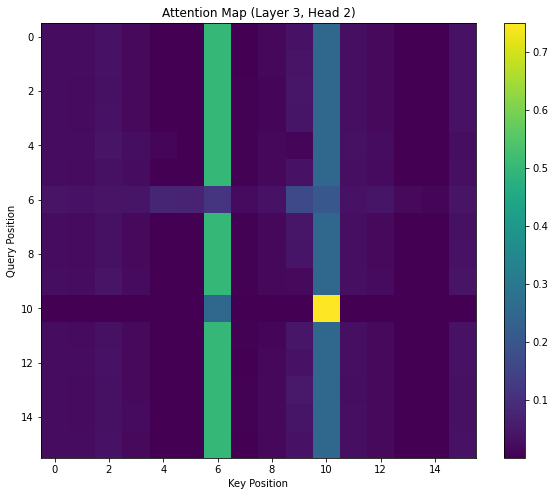

In [150]:
for i in range(5):
    model.eval()
    data, target = next(iter(val_loader))
    sample, label = data[0], target[0]

    with torch.no_grad():
        output = model(sample.unsqueeze(0))
        pred = output.argmax(dim=1).item()
    
    num_layers = len(model.attention_weights)
    num_heads = model.transformer_encoder.layers[0].self_attn.num_heads
    
    for layer in range(num_layers):
        for head in range(min(2, num_heads)):
            visualize_attention(model, sample, layer, head)

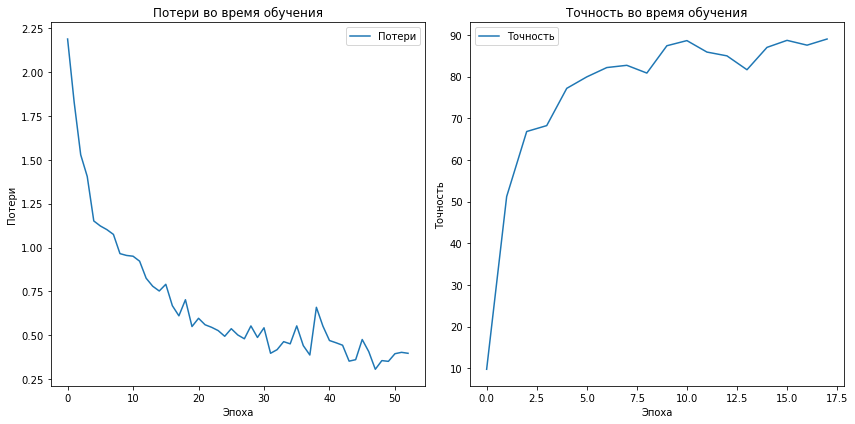

In [151]:
# Графики потерь и точности
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Потери')
plt.title('Потери во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vals, label='Точность')
plt.title('Точность во время обучения')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

В первых слоях видно, что модель активно распределяет внимание между различными признаками входных данных. Это подтверждает, что трансформер способен выделять важные характеристики каждого наблюдения, игнорируя менее значимые.